In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [36]:
def show3Channel(im):
    h,s,v = cv2.split(im)
    fig, ax = plt.subplots(1, 3, figsize=(16*3, 9*3))
    ax[0].imshow(h, cmap='gray')
    ax[1].imshow(s, cmap='gray')
    ax[2].imshow(v, cmap='gray')
    pcm = ax[0].pcolormesh(h, cmap = "gray")
    fig.colorbar(pcm, ax=ax[0], orientation='horizontal')
    pcm = ax[1].pcolormesh(s, cmap = "gray")
    fig.colorbar(pcm, ax=ax[1], orientation='horizontal')
    pcm = ax[2].pcolormesh(v, cmap = "gray")
    fig.colorbar(pcm, ax=ax[2], orientation='horizontal')
    plt.show()

def adjustChannelVals(im, channelScales):
    h,s,v = cv2.split(im)
    h = cv2.multiply(h, channelScales[0])
    s = cv2.multiply(s, channelScales[1])
    v = cv2.multiply(v, channelScales[2])
    h = cv2.add(h, channelScales[3])
    s = cv2.add(s, channelScales[4])
    v = cv2.add(v, channelScales[5])
    return cv2.merge((h,s,v))

In [37]:
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
parameters = cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX
ArucoDetector = cv2.aruco.ArucoDetector(dictionary, parameters)

In [38]:
#aruco test
im = cv2.imread('frame12.jpg')
grayScale = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
(corners1, ids1, rejectedImgPoints) = ArucoDetector.detectMarkers(im)
corners1 = corners1[0][0]
im = cv2.imread("Slide1.PNG")
grayScale = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
(corners2, ids2, rejectedImgPoints) = ArucoDetector.detectMarkers(im)
corners2 = corners2[0][0]
#change order so 2 and 3 are swapped
temp = corners2[2].copy()
corners2[2] = corners2[3]
corners2[3] = temp
temp = corners1[2].copy()
corners1[2] = corners1[3]
corners1[3] = temp
print(corners1)
print(corners2)
#correct order [[0,0],[352,0],[0,352],[352,352]]

[[ 799.29834  245.40654]
 [1085.6609   251.38422]
 [ 808.1775   540.1768 ]
 [1109.2465   528.64386]]
[[317.55774   37.557724]
 [961.44226   37.557724]
 [317.55774  681.44226 ]
 [961.44226  681.44226 ]]


(1080, 1920, 3)
(720, 1280, 3)
[ 0.25705599  0.16446416  0.25561918  0.00591012 -0.00188629  0.00417845]


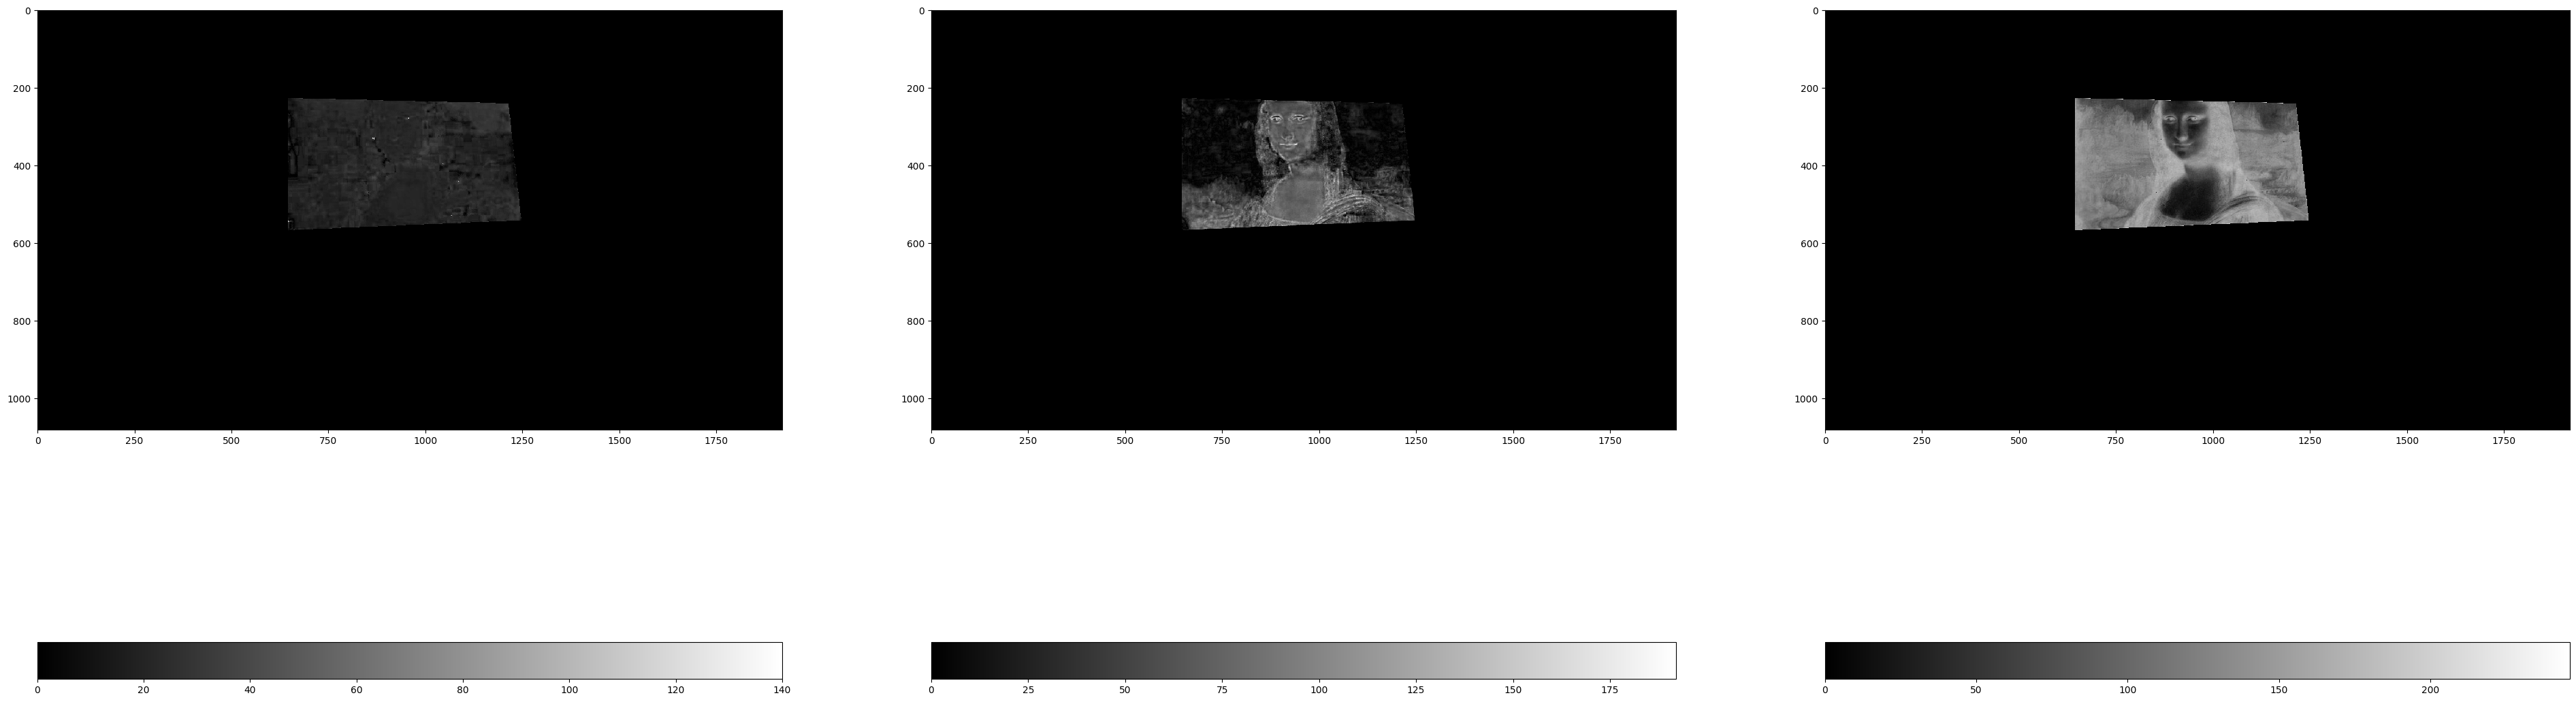

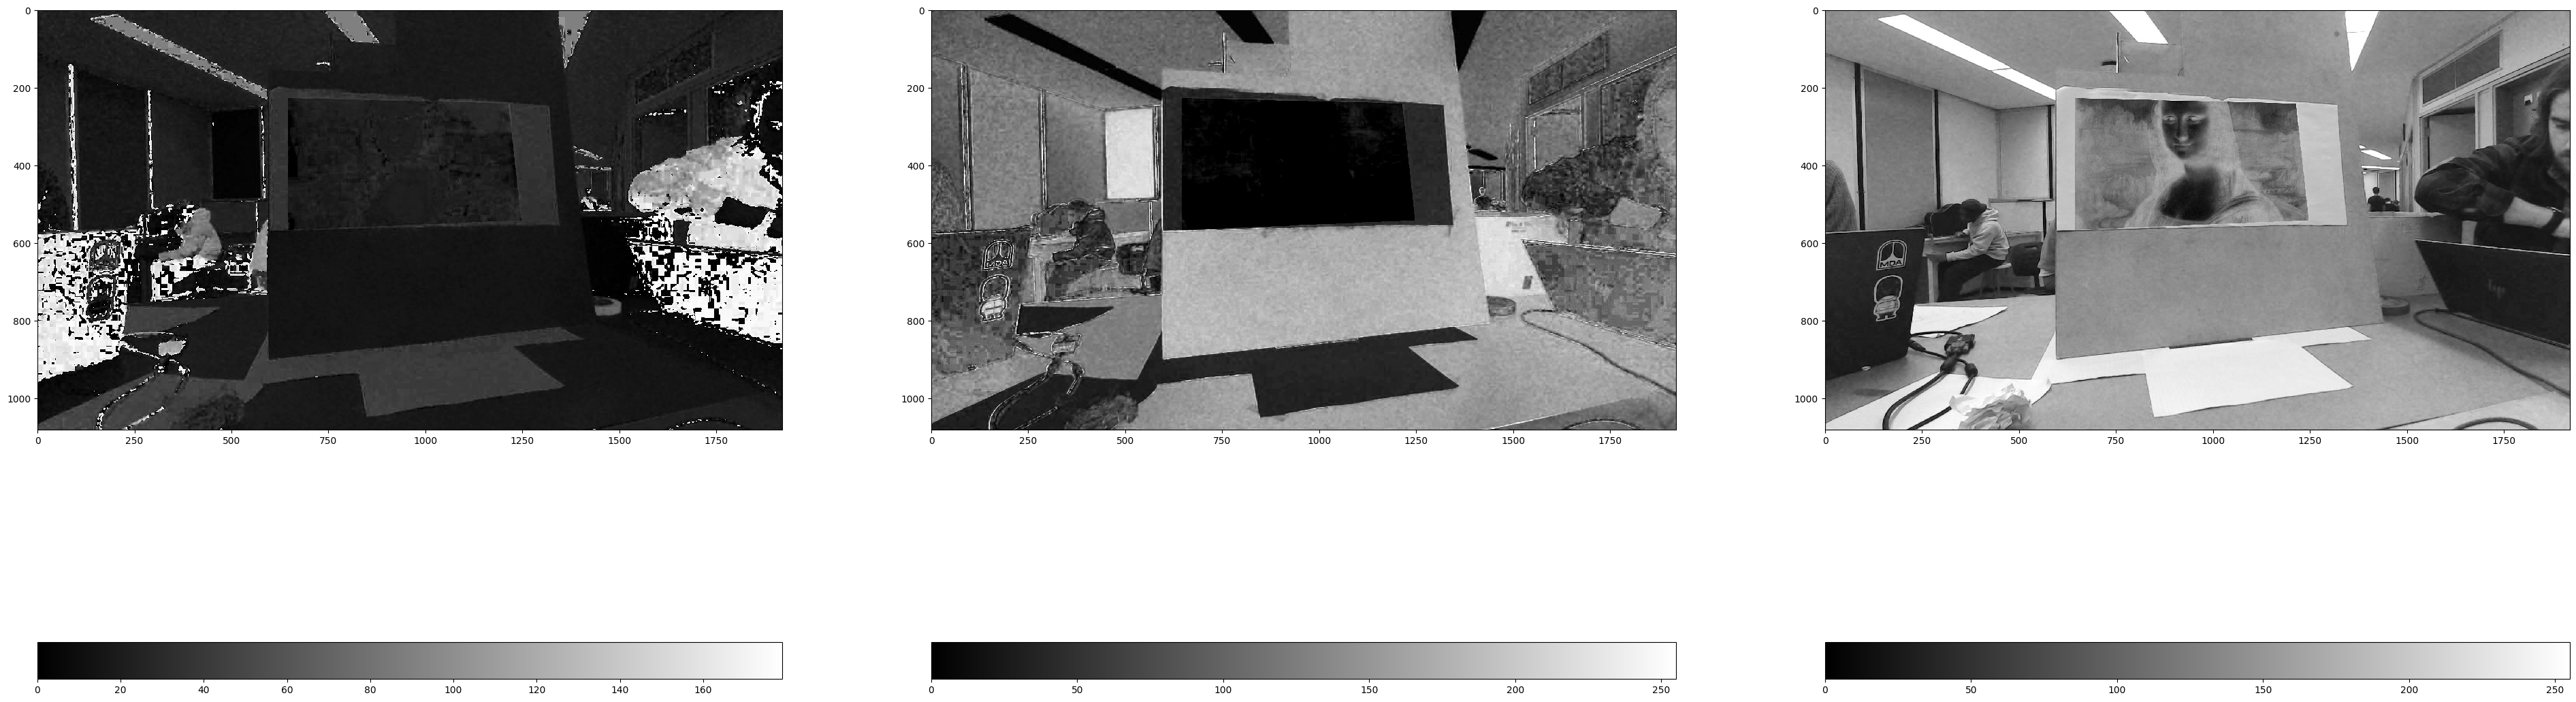

In [39]:
camPicture = cv2.imread("frame15.jpg")
camPicture = cv2.cvtColor(camPicture, cv2.COLOR_BGR2HSV)
row, col, ch = camPicture.shape
print(camPicture.shape)
refImage = cv2.imread("Slide3.PNG")
refImage = cv2.cvtColor(refImage, cv2.COLOR_BGR2HSV)
targetImage = cv2.imread("frame11.jpg")
targetImage = cv2.cvtColor(targetImage, cv2.COLOR_BGR2HSV)
#resize to 1920x1080
print(refImage.shape)
pts1 = np.float32(corners1)
pts2 = np.float32(corners2)
matrix = cv2.getPerspectiveTransform(pts2,pts1)
dst = cv2.warpPerspective(refImage,matrix,(col,row))
def subtractImage(channelScales, base, dist, target):
    mask = cv2.inRange(dist, np.array([1,1,1]), np.array([255,255,255]))
    dist = adjustChannelVals(dist, channelScales)
    
    h,s,v = cv2.split(base)
    h = cv2.bitwise_and(h, mask)
    s = cv2.bitwise_and(s, mask)
    v = cv2.bitwise_and(v, mask)
    base = cv2.merge((h,s,v))
    h,s,v = cv2.split(target)
    h = cv2.bitwise_and(h, mask)
    s = cv2.bitwise_and(s, mask)
    v = cv2.bitwise_and(v, mask)
    target = cv2.merge((h,s,v))
    sub = cv2.subtract(base, dist)
    diff = cv2.absdiff(sub, target)
    return np.sum(diff)
params = minimize(subtractImage, [1,1,1,0,0,0], args=(camPicture, dst, targetImage), method='Nelder-Mead', bounds=((-10, 10), (-10, 10), (-10, 10), (-255, 255), (-255, 255), (-255, 255)))
print(params.x)
mask = cv2.inRange(dst, np.array([1,1,1]), np.array([255,255,255]))
dist = adjustChannelVals(dst, params.x)
absDiff = cv2.absdiff(camPicture, dst)

#mask out the absDiff
h,s,v = cv2.split(absDiff)
h = cv2.bitwise_and(h, mask)
s = cv2.bitwise_and(s, mask)
v = cv2.bitwise_and(v, mask)
absDiff = cv2.merge((h,s,v))
sub = cv2.subtract(camPicture, dst)
show3Channel(absDiff)
show3Channel(sub)

    

(720, 1280, 3)


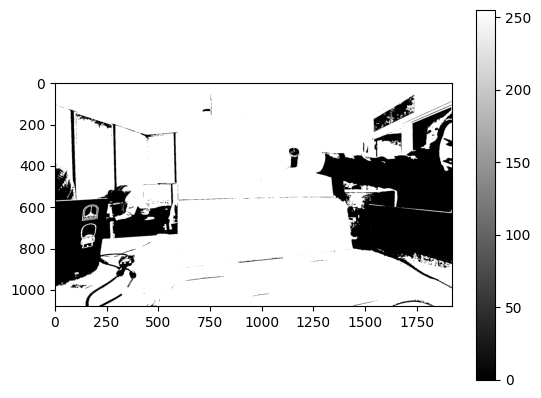

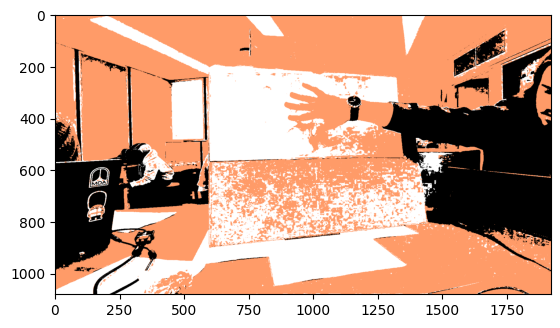

In [42]:
imWithHand = cv2.imread('frame16.jpg')
imWithHand = cv2.cvtColor(imWithHand, cv2.COLOR_BGR2HSV)
refImage = cv2.imread('Slide3.PNG')
print(np.shape(refImage))
refImage = cv2.cvtColor(refImage, cv2.COLOR_BGR2HSV)
dst = cv2.warpPerspective(refImage,matrix,(col,row))
dst = adjustChannelVals(dst, params.x)
sub = cv2.subtract(imWithHand, dst)
h,s,v = cv2.split(sub)
mask = cv2.inRange(s, 60, 180)
h= np.ones_like(h)*10
#shift saturation to 0
s= np.ones_like(h)*150
h = cv2.bitwise_and(h, mask)
s = cv2.bitwise_and(s, mask)
v = cv2.inRange(v, 80, 255)
plt.imshow(v, cmap='gray')
plt.colorbar()
plt.show()
sub = cv2.merge((h,s,v))
plt.imshow(cv2.cvtColor(sub, cv2.COLOR_HSV2RGB))
plt.show()

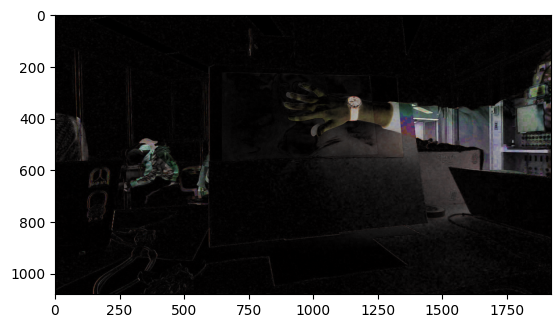

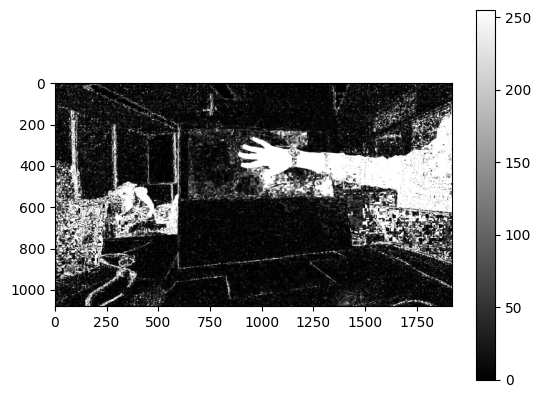

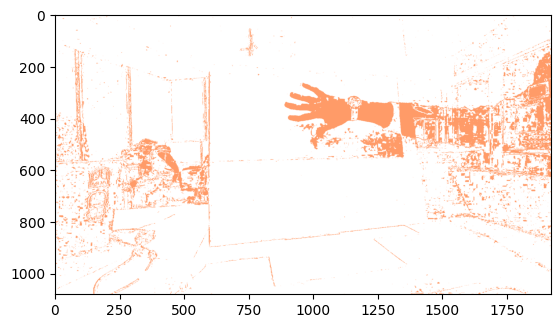

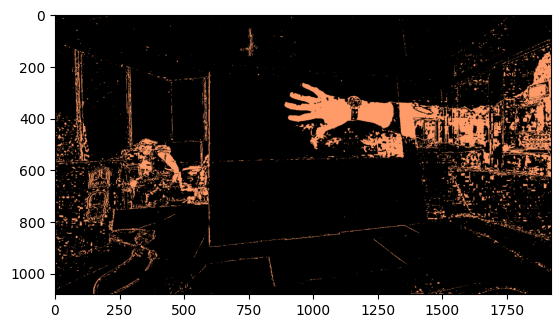

In [43]:
imWithHand = cv2.imread('frame16.jpg')
imWithHand = cv2.cvtColor(imWithHand, cv2.COLOR_BGR2HSV)
refImage = cv2.imread('Slide3.PNG')
refImage = cv2.cvtColor(refImage, cv2.COLOR_BGR2HSV)
targetImage = cv2.imread('frame11.jpg')
targetImage = cv2.cvtColor(targetImage, cv2.COLOR_BGR2HSV)
dst = cv2.warpPerspective(refImage,matrix,(col,row))
dst = adjustChannelVals(dst, params.x)
sub = cv2.subtract(imWithHand, dst)
DiffToTarget = cv2.absdiff(sub, targetImage)
sub2H, sub2S, sub2V = cv2.split(DiffToTarget)
plt.imshow(cv2.cvtColor(DiffToTarget, cv2.COLOR_HSV2RGB))
plt.show()
plt.imshow(cv2.multiply(sub2H, sub2S), cmap='gray')
plt.colorbar()
plt.show()
show3Channel(DiffToTarget)
mask = cv2.inRange(sub2S, 35, 255)
h= np.ones_like(h)*10
#shift saturation to 0
s= np.ones_like(h)*150
h = cv2.bitwise_and(h, mask)
s = cv2.bitwise_and(s, mask)
v = np.ones_like(h)*255
im = cv2.merge((h,s,v))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_HSV2RGB))
plt.show()
imSV = cv2.merge((h,s,cv2.bitwise_and(v, mask)))
plt.imshow(cv2.cvtColor(imSV, cv2.COLOR_HSV2RGB))
plt.show()